Installing log Files


In [1]:
# installation of library pm4py
%pip install pm4py

Note: you may need to restart the kernel to use updated packages.


Import Library


In [4]:
import pm4py
import tempfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualizer
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from IPython.display import Image
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.alpha import algorithm as alpha_mine

Read file Csv

In [5]:
df=pm4py.read_xes('Road_Traffic_Fine_Management_Process.xes')
log_df=pm4py.convert_to_dataframe(df)
log_df

parsing log, completed traces ::   0%|          | 0/150370 [00:00<?, ?it/s]

amount org:resource dismissal                concept:name  \
0         35.0          561       NIL                 Create Fine   
1          NaN          NaN       NaN                   Send Fine   
2         35.0          561       NIL                 Create Fine   
3          NaN          NaN       NaN                   Send Fine   
4          NaN          NaN       NaN    Insert Fine Notification   
...        ...          ...       ...                         ...   
561465   131.0           25       NIL                 Create Fine   
561466     NaN          NaN       NaN                   Send Fine   
561467     NaN          NaN       NaN    Insert Fine Notification   
561468   262.0          NaN       NaN                 Add penalty   
561469     NaN          NaN       NaN  Send for Credit Collection   

       vehicleClass  totalPaymentAmount lifecycle:transition  \
0                 A                 0.0             complete   
1               NaN                 NaN             complete   
2                 A                 0.0             complete   
3               NaN                 NaN             complete   
4               NaN                 NaN             complete   
...             ...                 ...                  ...   
561465            A                 0.0             complete   
561466          NaN                 NaN             complete   
561467          NaN                 NaN             complete   
561468          NaN                 NaN             complete   
561469          NaN                 NaN             complete   

                  time:timestamp  article  points case:concept:name  expense  \
0      2006-07-24 00:00:00+00:00    157.0     0.0                A1      NaN   
1      2006-12-05 00:00:00+00:00      NaN     NaN                A1    11.00   
2      2006-08-02 00:00:00+00:00    157.0     0.0              A100      NaN   
3      2006-12-12 00:00:00+00:00      NaN     NaN              A100    11.00   
4      2007-01-15 00:00:00+00:00      NaN     NaN              A100      NaN   
...                          ...      ...     ...               ...      ...   
561465 2002-09-07 00:00:00+00:00    142.0     0.0             V9999      NaN   
561466 2002-10-25 00:00:00+00:00      NaN     NaN             V9999    15.16   
561467 2002-11-04 00:00:00+00:00      NaN     NaN             V9999      NaN   
561468 2003-01-03 00:00:00+00:00      NaN     NaN             V9999      NaN   
561469 2004-01-10 00:00:00+00:00      NaN     NaN             V9999      NaN   

       notificationType lastSent  paymentAmount  matricola  
0                   NaN      NaN            NaN        NaN  
1                   NaN      NaN            NaN        NaN  
2                   NaN      NaN            NaN        NaN  
3                   NaN      NaN            NaN        NaN  
4                     P        P            NaN        NaN  
...                 ...      ...            ...        ...  
561465              NaN      NaN            NaN        NaN  
561466              NaN      NaN            NaN        NaN  
561467                P        N            NaN        NaN  
561468              NaN      NaN            NaN        NaN  
561469              NaN      NaN            NaN        NaN  

[561470 rows x 16 columns]

Print Number Event and Cases 

In [6]:
num_events = len(log_df)
num_cases = len(log_df['case:concept:name'].unique())
print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))
start_activities = pm4py.get_start_activities(log_df)
end_activities = pm4py.get_end_activities(log_df)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

Number of events: 561470
Number of cases: 150370
Start activities: {'Create Fine': 150370}
End activities: {'Send Fine': 20755, 'Send for Credit Collection': 58997, 'Payment': 67201, 'Send Appeal to Prefecture': 3144, 'Appeal to Judge': 134, 'Notify Result Appeal to Offender': 86, 'Receive Result Appeal from Prefecture': 53}


Drop Duplicate

In [7]:
log_df = log_df.drop_duplicates()
log_df.reset_index(drop=True, inplace=True)
len(log_df)

561470

Case Duration

In [8]:
case_durations = log_df.groupby('case:concept:name').agg(\
Events=('case:concept:name', 'count'),\
FirstOccurence=('time:timestamp', lambda x: x.min()),
LastOccurence=('time:timestamp', lambda x: x.max()),
Duration=('time:timestamp', lambda x: x.max() - x.min())
)
case_durations

Events            FirstOccurence             LastOccurence  \
case:concept:name                                                               
A1                      2 2006-07-24 00:00:00+00:00 2006-12-05 00:00:00+00:00   
A100                    5 2006-08-02 00:00:00+00:00 2009-03-30 00:00:00+00:00   
A10000                  5 2007-03-09 00:00:00+00:00 2008-09-09 00:00:00+00:00   
A10001                  6 2007-03-19 00:00:00+00:00 2007-09-24 00:00:00+00:00   
A10004                  5 2007-03-20 00:00:00+00:00 2009-03-30 00:00:00+00:00   
...                   ...                       ...                       ...   
V9995                   5 2002-09-07 00:00:00+00:00 2004-01-10 00:00:00+00:00   
V9996                   3 2002-09-07 00:00:00+00:00 2002-11-06 00:00:00+00:00   
V9997                   5 2002-09-07 00:00:00+00:00 2004-01-10 00:00:00+00:00   
V9998                   5 2002-09-07 00:00:00+00:00 2004-01-10 00:00:00+00:00   
V9999                   5 2002-09-07 00:00:00+00:00 2004-01-10 00:00:00+00:00   

                  Duration  
case:concept:name           
A1                134 days  
A100              971 days  
A10000            550 days  
A10001            189 days  
A10004            741 days  
...                    ...  
V9995             490 days  
V9996              60 days  
V9997             490 days  
V9998             490 days  
V9999             490 days  

[150370 rows x 4 columns]

Columns Names 

In [9]:
# Get the column names
columns = log_df.columns

# Print all the columns
for column in columns:
    print(column)

amount
org:resource
dismissal
concept:name
vehicleClass
totalPaymentAmount
lifecycle:transition
time:timestamp
article
points
case:concept:name
expense
notificationType
lastSent
paymentAmount
matricola


Get variants 

In [10]:
variants = pm4py.get_variants(log_df)
variants = sorted(variants.items(), key=lambda x: x[1],reverse=True)
variants

[(('Create Fine',
   'Send Fine',
   'Insert Fine Notification',
   'Add penalty',
   'Send for Credit Collection'),
  56482),
 (('Create Fine', 'Payment'), 46371),
 (('Create Fine', 'Send Fine'), 20385),
 (('Create Fine',
   'Send Fine',
   'Insert Fine Notification',
   'Add penalty',
   'Payment'),
  9520),
 (('Create Fine',
   'Send Fine',
   'Insert Fine Notification',
   'Add penalty',
   'Payment',
   'Payment'),
  3736),
 (('Create Fine',
   'Send Fine',
   'Insert Fine Notification',
   'Payment',
   'Add penalty',
   'Payment'),
  3301),
 (('Create Fine', 'Send Fine', 'Payment'), 3131),
 (('Create Fine',
   'Send Fine',
   'Insert Fine Notification',
   'Insert Date Appeal to Prefecture',
   'Add penalty',
   'Send Appeal to Prefecture'),
  2497),
 (('Create Fine',
   'Send Fine',
   'Insert Fine Notification',
   'Add penalty',
   'Payment',
   'Send for Credit Collection'),
  1515),
 (('Create Fine',
   'Send Fine',
   'Insert Fine Notification',
   'Payment',
   'Add penal

Plot Variants

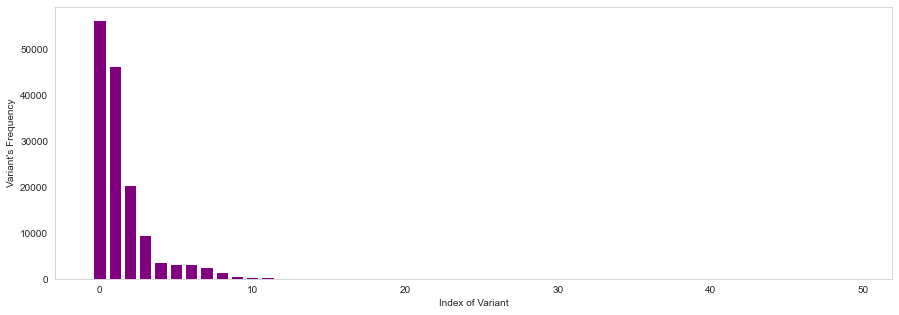

In [11]:
values = [item[1] for item in variants[:50]]
plt.figure(figsize=(15, 5))
plt.grid()
plt.xlabel('Index of Variant')
plt.ylabel('Variant\'s Frequency')
plt.bar(range(len(values)), values, color='purple')
plt.show()

activity frequency we compute frequency of activities:

In [12]:
frequency = log_df["concept:name"].value_counts().reset_index()
frequency.columns = ["concept:name", "Frequency"]
total = frequency["Frequency"].sum()
frequency["Percentage"] = frequency["Frequency"] / total * 100
frequency.index = frequency.index + 1
frequency[:20]

concept:name  Frequency  Percentage
1                             Create Fine     150370   26.781484
2                               Send Fine     103987   18.520491
3                Insert Fine Notification      79860   14.223378
4                             Add penalty      79860   14.223378
5                                 Payment      77601   13.821041
6              Send for Credit Collection      59013   10.510446
7        Insert Date Appeal to Prefecture       4188    0.745899
8               Send Appeal to Prefecture       4141    0.737528
9   Receive Result Appeal from Prefecture        999    0.177926
10       Notify Result Appeal to Offender        896    0.159581
11                        Appeal to Judge        555    0.098848

It is a good consideration to check the list of start and end activities. we can use this list to detect some anomalies and use it during filtering phase:

In [13]:
log_start = pm4py.get_start_activities(df)
log_end = pm4py.get_end_activities(df)

In [14]:
log_start

{'Create Fine': 150370}

In [15]:
log_end

{'Send Fine': 20755,
 'Send for Credit Collection': 58997,
 'Payment': 67201,
 'Send Appeal to Prefecture': 3144,
 'Appeal to Judge': 134,
 'Notify Result Appeal to Offender': 86,
 'Receive Result Appeal from Prefecture': 53}

Plot Category Frequency

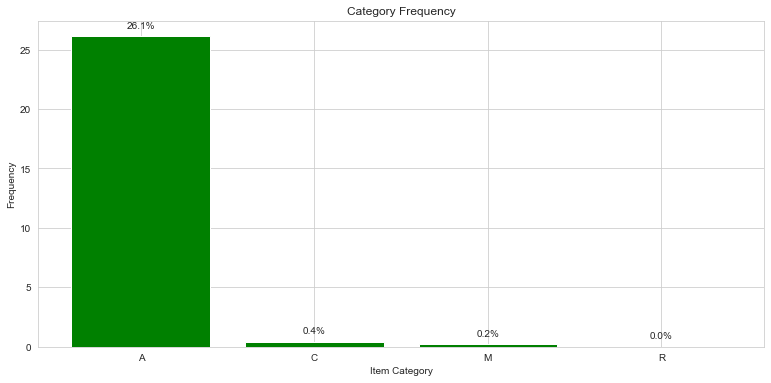

In [16]:
category_frequencies = (log_df.groupby('vehicleClass').size() / len(log_df)) * 100
plt.figure(figsize=(13, 6))
plt.bar(category_frequencies.index, category_frequencies.values, color='green')
plt.xlabel('Item Category')
plt.ylabel('Frequency')
plt.title('Category Frequency')
for i, v in enumerate(category_frequencies.values):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')
plt.show()

# **apply filter and noise removal**
he code filters an event log based on case performance criteria, specifically selecting cases with a duration between 60 seconds and 21 days, and assigns the filtered log to the variable filtered_log.

Number of cases: 71500


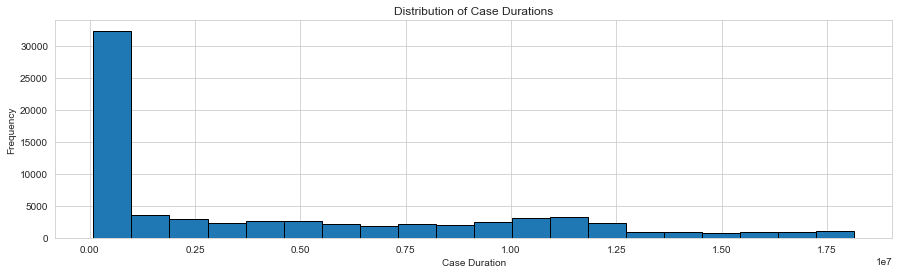

In [17]:
filtered_log = pm4py.filter_case_performance(log_df, 60, 18144000)
durations = pm4py.get_all_case_durations(filtered_log)
print("Number of cases:", len(durations))
plt.figure(figsize=(15, 4))
plt.hist(durations, bins=20, edgecolor='black')
plt.xlabel('Case Duration')
plt.ylabel('Frequency')
plt.title('Distribution of Case Durations')
plt.show()

Remaining Cases

In [18]:
k = 50
filtered_log = pm4py.filter_variants_top_k(filtered_log, k)
print("remaining cases:",len(pm4py.get_all_case_durations(filtered_log)))

remaining cases: 71477


#**process discovery** 

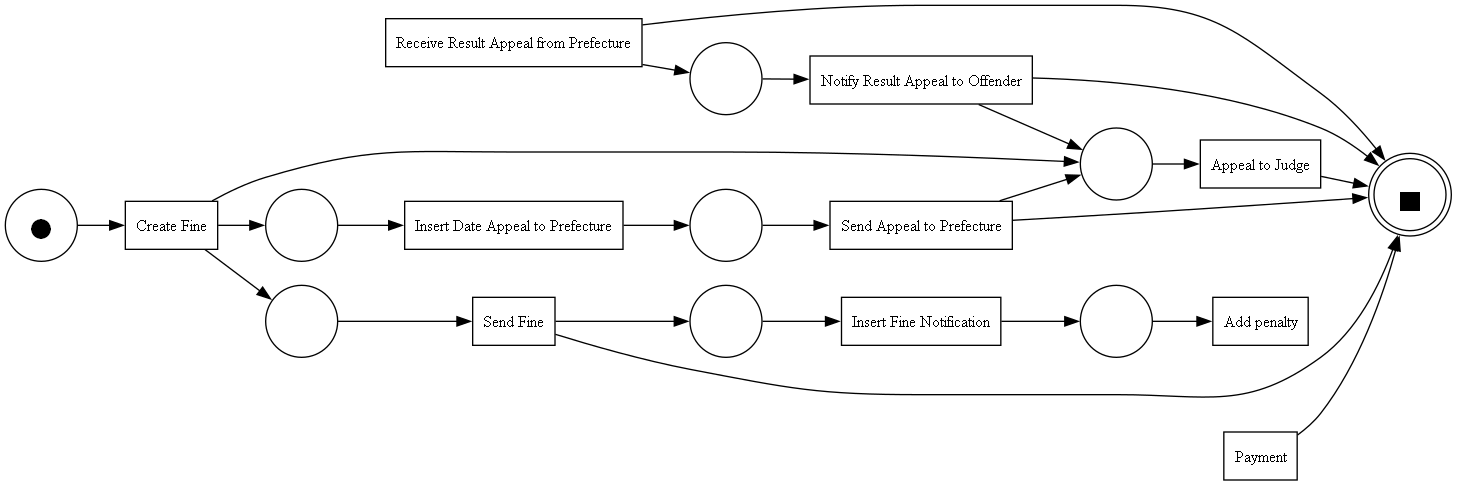

In [19]:
#alpha miner
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(filtered_log)
pm4py.view_petri_net(net, initial_marking, final_marking)

In [20]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
print("replay based fitness:",
      pm4py.fitness_token_based_replay(filtered_log, net, initial_marking, final_marking))

replaying log with TBR, completed traces ::   0%|          | 0/50 [00:00<?, ?it/s]

replay based fitness: {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.7246730821587704, 'log_fitness': 0.7311278532910253, 'percentage_of_fitting_traces': 0.0}


In [21]:
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
print("replay based precision:",pm4py.precision_token_based_replay(filtered_log, net, initial_marking, final_marking))

replaying log with TBR, completed traces ::   0%|          | 0/58 [00:00<?, ?it/s]

replay based precision: 0.5434155246373087


In [22]:
print("generalization:",generalization_evaluator.apply(filtered_log, net, initial_marking, final_marking))

replaying log with TBR, completed traces ::   0%|          | 0/50 [00:00<?, ?it/s]

generalization: 0.9528722733097428


In [1]:
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
simp_alpha = simplicity_evaluator.apply(net)
print(simp_alpha)

KeyboardInterrupt: 

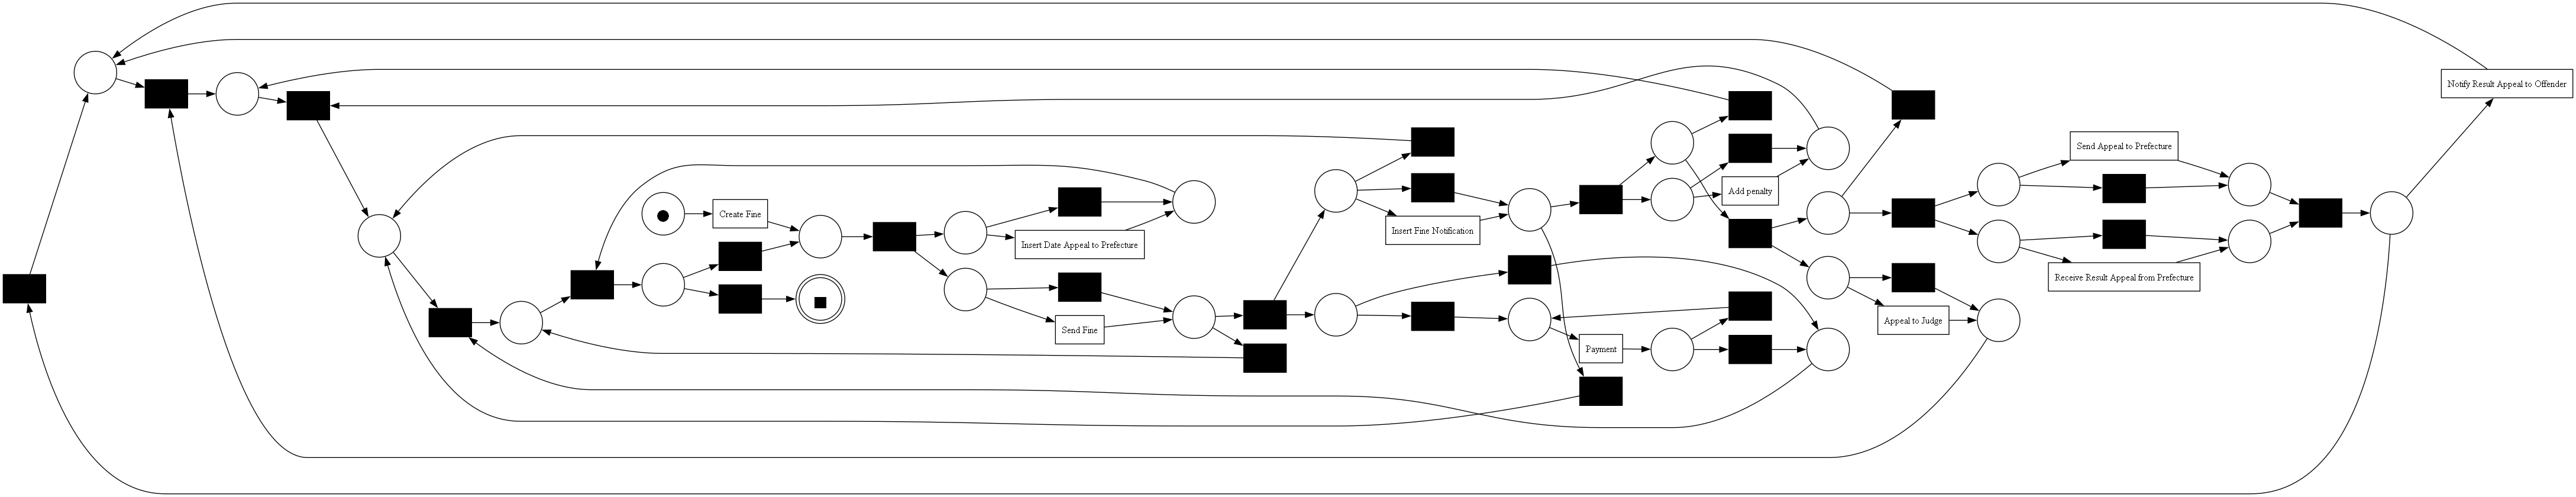

In [24]:
# inductive miner
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(filtered_log)
pm4py.view_petri_net(net, initial_marking, final_marking)

In [25]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

# Discover process model using inductive miner
model = inductive_miner.apply(filtered_log)


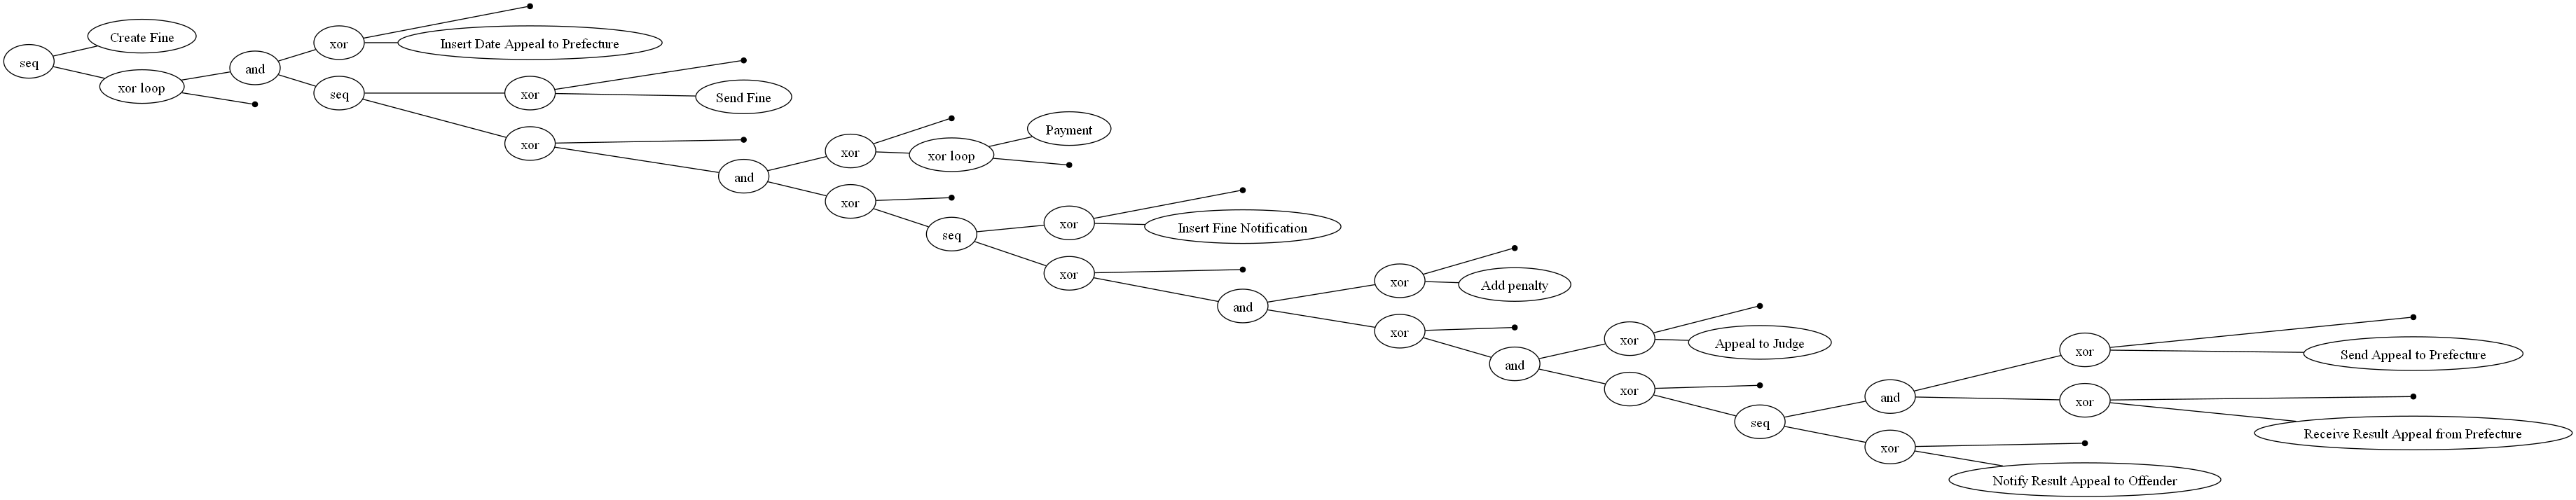

In [26]:
from pm4py.visualization.process_tree import visualizer as pt_visualizer
gviz = pt_visualizer.apply(model, parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
pt_visualizer.view(gviz)

replaying log with TBR, completed traces ::   0%|          | 0/50 [00:00<?, ?it/s]

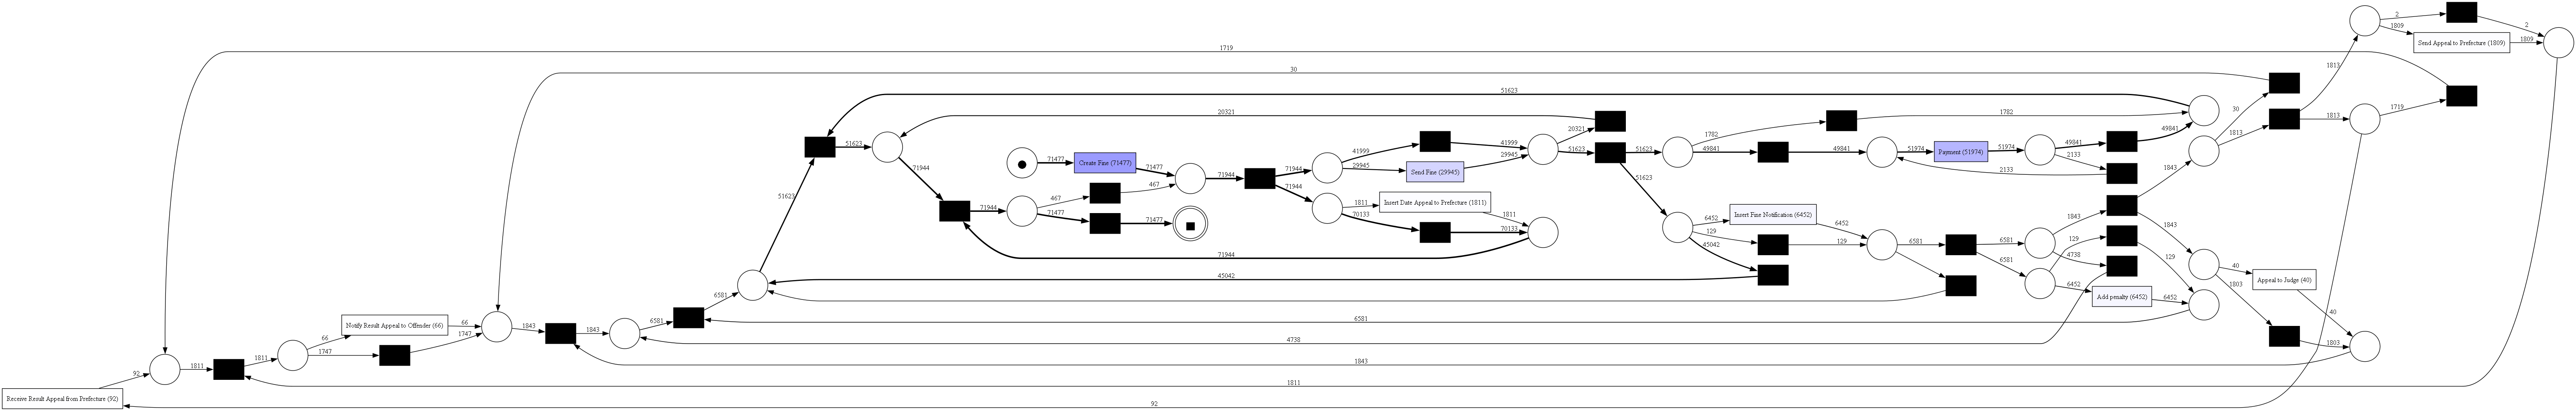

In [27]:
from pm4py.objects.conversion.process_tree import converter as pt_converter
net, initial_marking, final_marking = pt_converter.apply(model)
## Then visualise
gviz = pn_visualizer.apply(net, initial_marking, final_marking,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=filtered_log)
pn_visualizer.view(gviz)

In [28]:
fitness_inductive = replay_fitness_evaluator.apply(filtered_log, net, initial_marking, final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(fitness_inductive)

replaying log with TBR, completed traces ::   0%|          | 0/50 [00:00<?, ?it/s]

{'perc_fit_traces': 99.99720189711375, 'average_trace_fitness': 0.9999991715420867, 'log_fitness': 0.9999970188922733, 'percentage_of_fitting_traces': 99.99720189711375}


In [29]:
prec_inductive = precision_evaluator.apply(filtered_log, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print(prec_inductive)

replaying log with TBR, completed traces ::   0%|          | 0/58 [00:00<?, ?it/s]

0.5115746845781473


In [30]:
print("generalization:",generalization_evaluator.apply(filtered_log, net, initial_marking, final_marking))

replaying log with TBR, completed traces ::   0%|          | 0/50 [00:00<?, ?it/s]

generalization: 0.9260935254656915


In [31]:
simp_inductive = simplicity_evaluator.apply(net)
print(simp_inductive)

0.6296296296296295


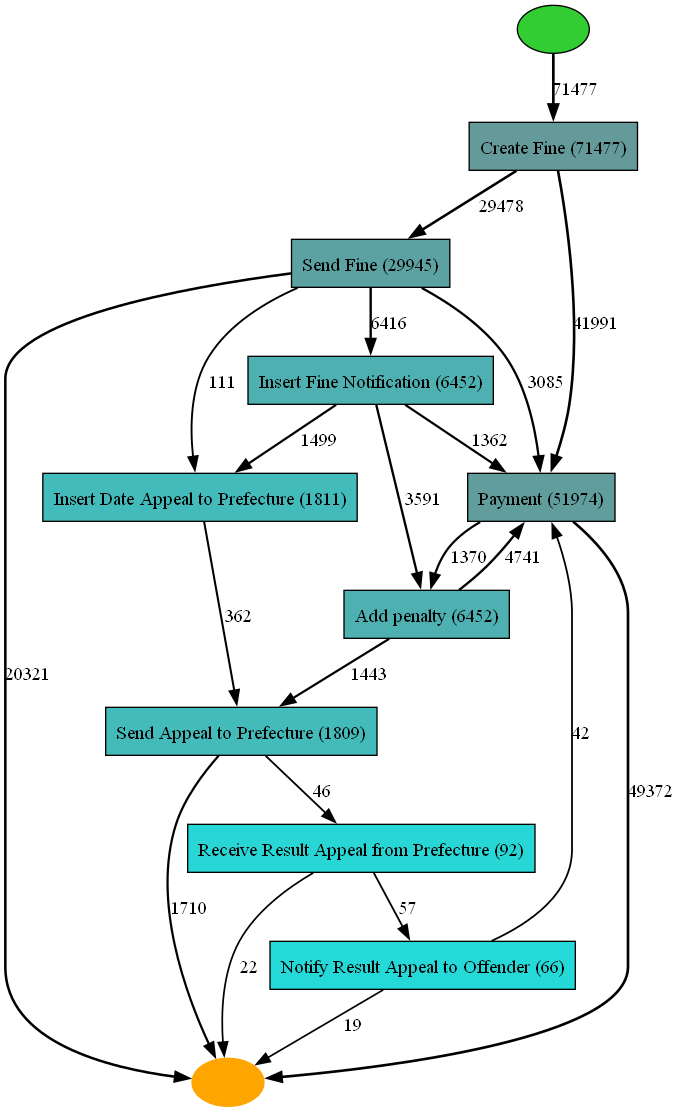

In [32]:
#Heuristic miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
net = heuristics_miner.apply_heu(filtered_log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.9})
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
gviz = hn_visualizer.apply(net)
hn_visualizer.view(gviz)

replaying log with TBR, completed traces ::   0%|          | 0/50 [00:00<?, ?it/s]

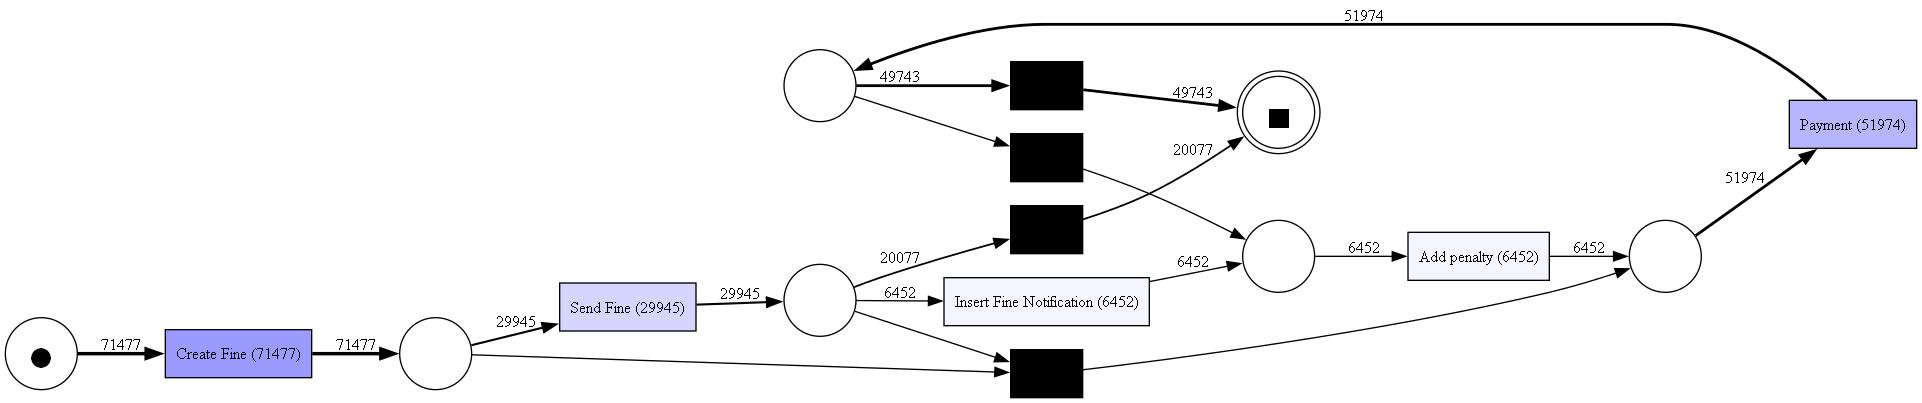

In [33]:
net, initial_marking, final_marking = heuristics_miner.apply(filtered_log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.9995})

gviz = pn_visualizer.apply(net, initial_marking, final_marking, variant=pn_visualizer.Variants.FREQUENCY, log=filtered_log)
pn_visualizer.view(gviz)

# Segmenting Data

In this section, we try to perform our analysis on subsection of log file. we divide log file into 4 categories and then perform above mentioned operations on each one.



In [34]:
def categorizeLogFile(log,categories):
  return {
        item: pm4py.filter_event_attribute_values(log_df, "vehicleClass", [item], level="case", retain=True)
        for item in categories
    }
segmentedData = categorizeLogFile(log_df,["A", "C","M", "R"])


In [35]:
log_df["concept:name"].value_counts()

concept:name
Create Fine                              150370
Send Fine                                103987
Insert Fine Notification                  79860
Add penalty                               79860
Payment                                   77601
Send for Credit Collection                59013
Insert Date Appeal to Prefecture           4188
Send Appeal to Prefecture                  4141
Receive Result Appeal from Prefecture       999
Notify Result Appeal to Offender            896
Appeal to Judge                             555
Name: count, dtype: int64

In [36]:
def filter(input):
  log = input.copy()
  log = pm4py.filter_case_performance(log, 60, 18144000)
  log = pm4py.filter_variants_top_k(log, k)
  log = pm4py.filter_start_activities(log,["Create Fine"])
  log = pm4py.filter_end_activities(log, [
  "Create Fine",
  "Send Fine",
  "Insert Fine Notification",
  "Add penalty",
  "Payment",
  "Send for Credit Collection",
  "Insert Date Appeal to Prefecture",
  "Send Appeal to Prefecture",
  "Receive Result Appeal from Prefecture",
  "Notify Result Appeal to Offender"])
  cases_to_exclude = pd.concat([
    pm4py.filter_activities_rework(log, "Send Fine", 2),
    pm4py.filter_activities_rework(log, "Insert Fine Notification", 2),
    pm4py.filter_activities_rework(log, "Add penalty", 2)
    ])
  cases_to_exclude = cases_to_exclude["case:concept:name"].unique()
  log = log[~log['case:concept:name'].isin(cases_to_exclude)]
  return log



In [37]:
for item in segmentedData:
  print("number of cases in",item," before filtering:", len(segmentedData[item]))
  segmentedData[item] = filter(segmentedData[item])
  print("number of cases in",item," after filtering:", len(segmentedData[item]))
  print("\n")


number of cases in A  before filtering: 545846
number of cases in A  after filtering: 165945


number of cases in C  before filtering: 10346
number of cases in C  after filtering: 2752


number of cases in M  before filtering: 5262
number of cases in M  after filtering: 1271


number of cases in R  before filtering: 16
number of cases in R  after filtering: 6




#**PlotCategories**

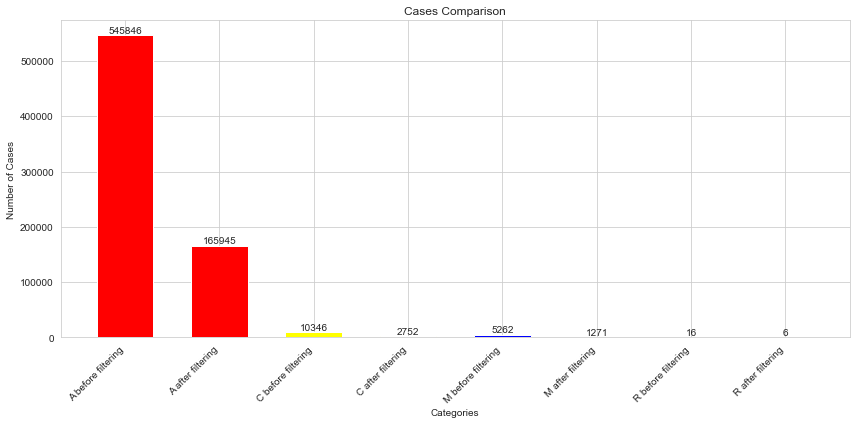

In [38]:
import matplotlib.pyplot as plt

categories = [
    'A before filtering',
    'A after filtering',
    'C before filtering',
    'C after filtering',
    'M before filtering',
    'M after filtering',
    'R before filtering',
    'R after filtering'
]
values = [545846, 165945, 10346, 2752, 5262, 1271, 16, 6]

colors = ['red', 'red', 'yellow', 'yellow', 'blue', 'blue', 'green', 'green']

fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.6  # Adjust the width of the bars

bars = ax.bar(range(len(categories)), values, color=colors, width=bar_width)

for bar, value in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(value), ha='center', va='bottom')

ax.set_xlabel('Categories')
ax.set_ylabel('Number of Cases')
ax.set_title('Cases Comparison')

ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, rotation=45, ha='right')

plt.tight_layout()  # Adjust the layout

plt.show()


In [39]:
#for the 3-way match, invoice after GR, it should contains "Record Goods Receipt" and also "Record Invoice Receipt"
segmentedData["A"] = pm4py.filter_activities_rework(segmentedData["A"], "Create Fine", 1)
segmentedData["A"] = pm4py.filter_activities_rework(segmentedData["A"], "Send Fine", 1)
print("size of \"A\" after filter:",len(segmentedData["A"]))

size of "A" after filter: 84055


In [40]:
#for the 3-way matching, invoice before goods receipt, it should contains "Record Goods Receipt"
segmentedData["C"] = pm4py.filter_activities_rework(segmentedData["C"], "Create Fine", 1)
print("size of \"C\" after filter:",len(segmentedData["C"]))

size of "C" after filter: 2752


In [41]:
for item in segmentedData:
  print(item)

A
C
M
R


A


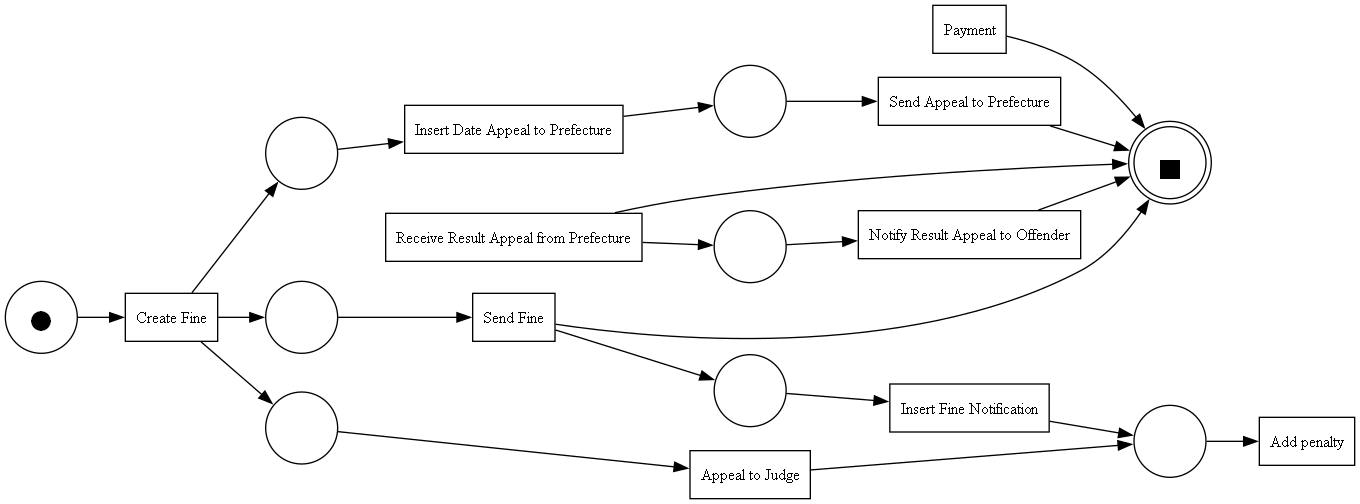

replaying log with TBR, completed traces ::   0%|          | 0/43 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/58 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/43 [00:00<?, ?it/s]

replay based fitness: {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.760761371843525, 'log_fitness': 0.7649858820261992, 'percentage_of_fitting_traces': 0.0}
replay based precision: 0.5344156743817301
generalization: 0.9290023346270082
simplicity: 0.826086956521739
C


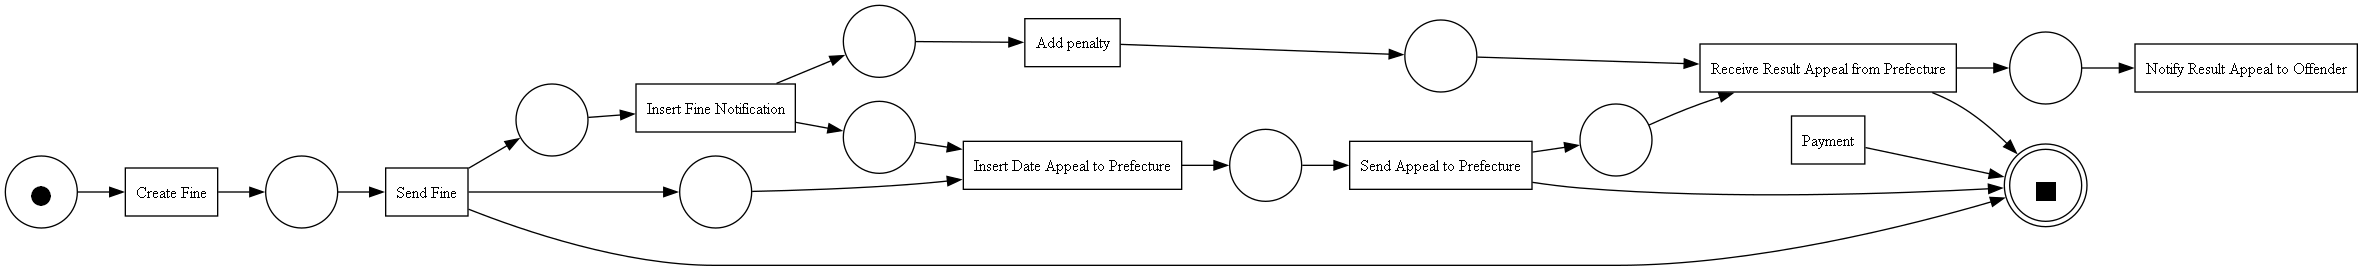

replaying log with TBR, completed traces ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/15 [00:00<?, ?it/s]

replay based fitness: {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.809193637173514, 'log_fitness': 0.8010532976389506, 'percentage_of_fitting_traces': 0.0}
replay based precision: 0.6883910386965377
generalization: 0.8068765947417209
simplicity: 0.7692307692307694
M


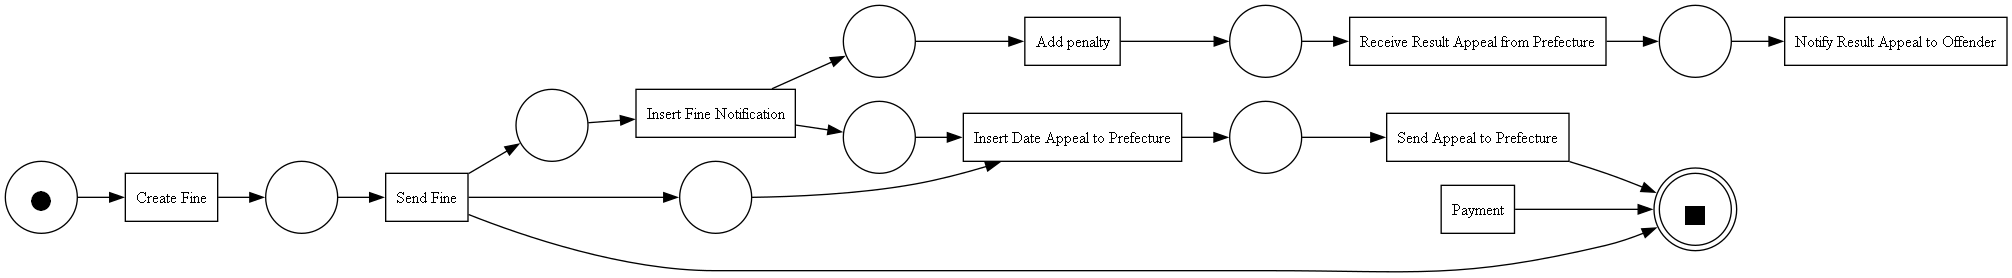

replaying log with TBR, completed traces ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/13 [00:00<?, ?it/s]

replay based fitness: {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.8097739965795537, 'log_fitness': 0.8061376890616851, 'percentage_of_fitting_traces': 0.0}
replay based precision: 0.6696468484577559
generalization: 0.6990945618639655
simplicity: 0.9047619047619049
R


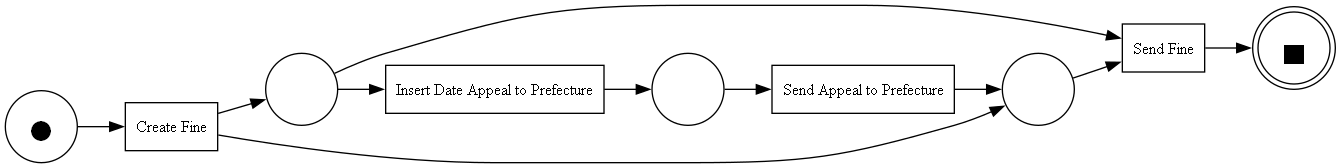

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replay based fitness: {'perc_fit_traces': 50.0, 'average_trace_fitness': 0.9166666666666667, 'log_fitness': 0.9, 'percentage_of_fitting_traces': 50.0}
replay based precision: 1.0
generalization: 0.14644660940672627
simplicity: 0.8181818181818181


In [42]:
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
#alpha miner
alpha_miner_heatmap = {}
for item in segmentedData:
  print(item)
  net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(segmentedData[item])
  pm4py.view_petri_net(net, initial_marking, final_marking)

  fitness = pm4py.fitness_token_based_replay(segmentedData[item], net, initial_marking, final_marking)
  precision = pm4py.precision_token_based_replay(segmentedData[item], net, initial_marking, final_marking)
  generalization = generalization_evaluator.apply(segmentedData[item], net, initial_marking, final_marking)
  simplicity = simplicity_evaluator.apply(net)

  alpha_miner_heatmap[item] = [fitness["log_fitness"],precision,generalization,simplicity]

  print("replay based fitness:", fitness)
  print("replay based precision:", precision)
  print("generalization:",generalization)
  print("simplicity:",simplicity)

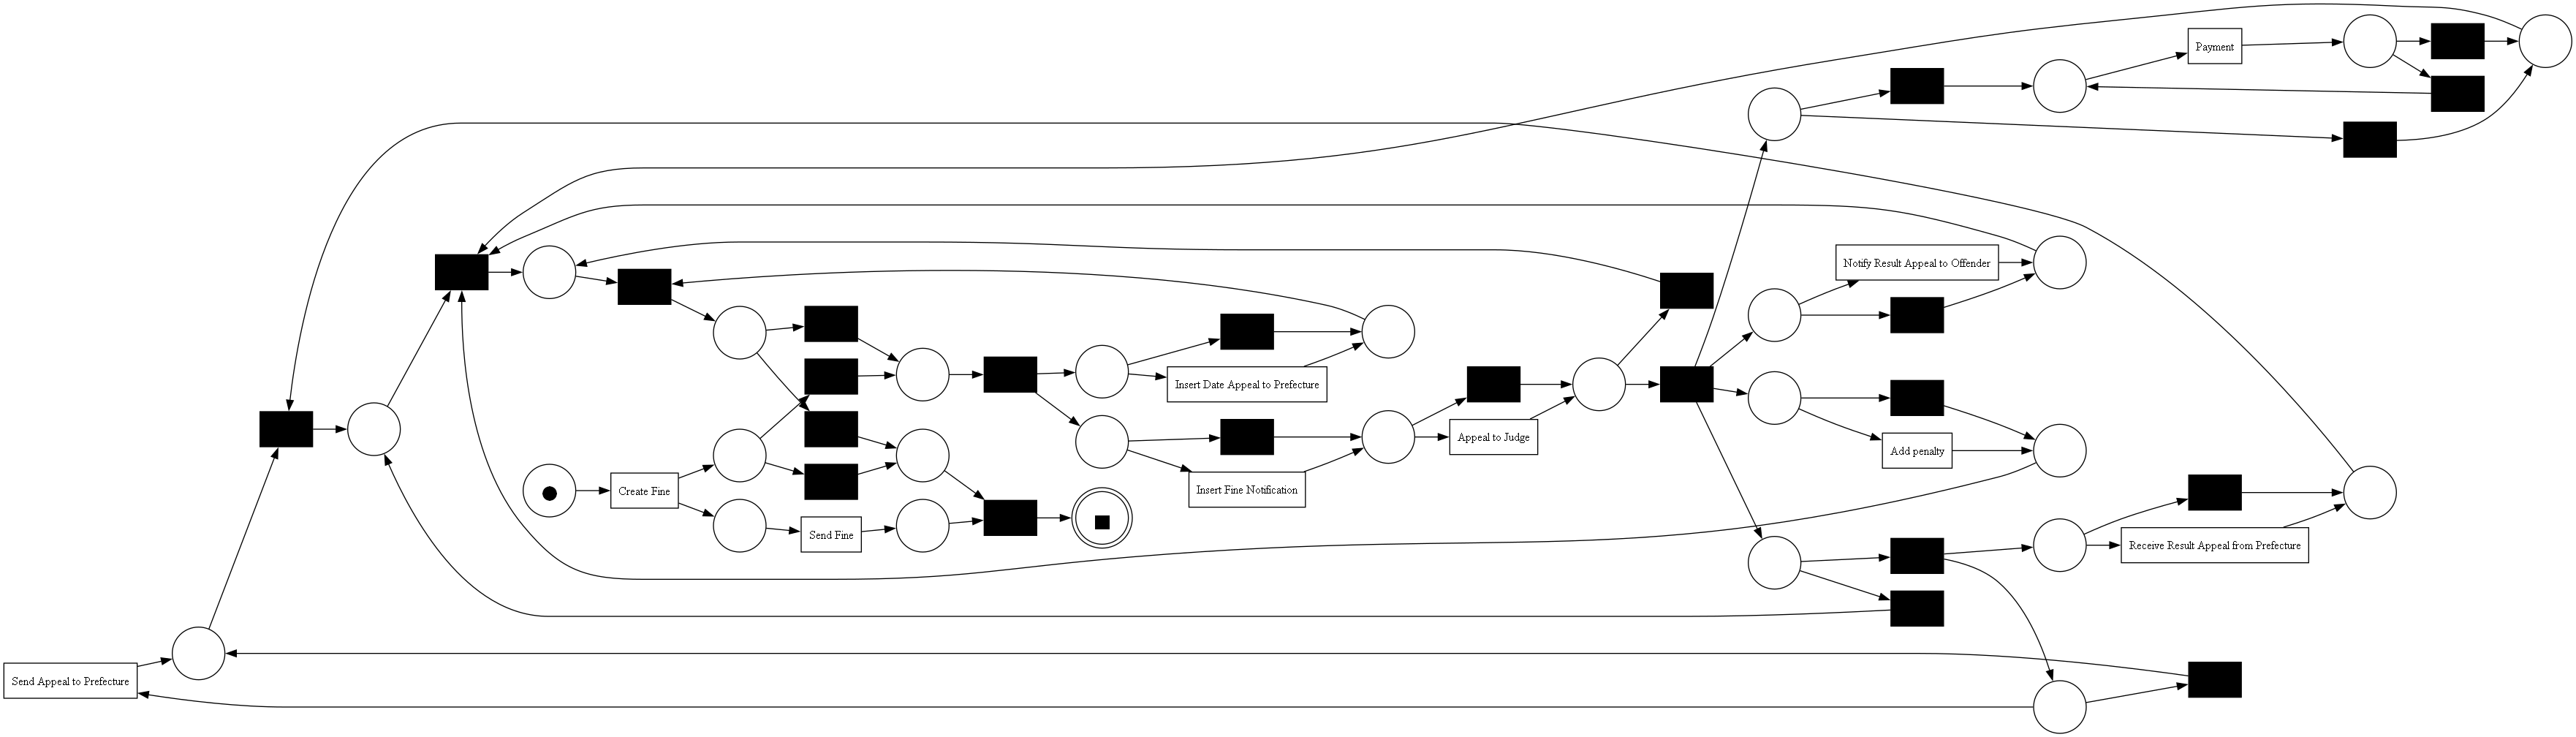

replaying log with TBR, completed traces ::   0%|          | 0/43 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/58 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/43 [00:00<?, ?it/s]

Item: A
Replay-based fitness: 1.0
Replay-based precision: 0.5019946171546112
Generalization: 0.925490928459501
Simplicity: 0.6326530612244898



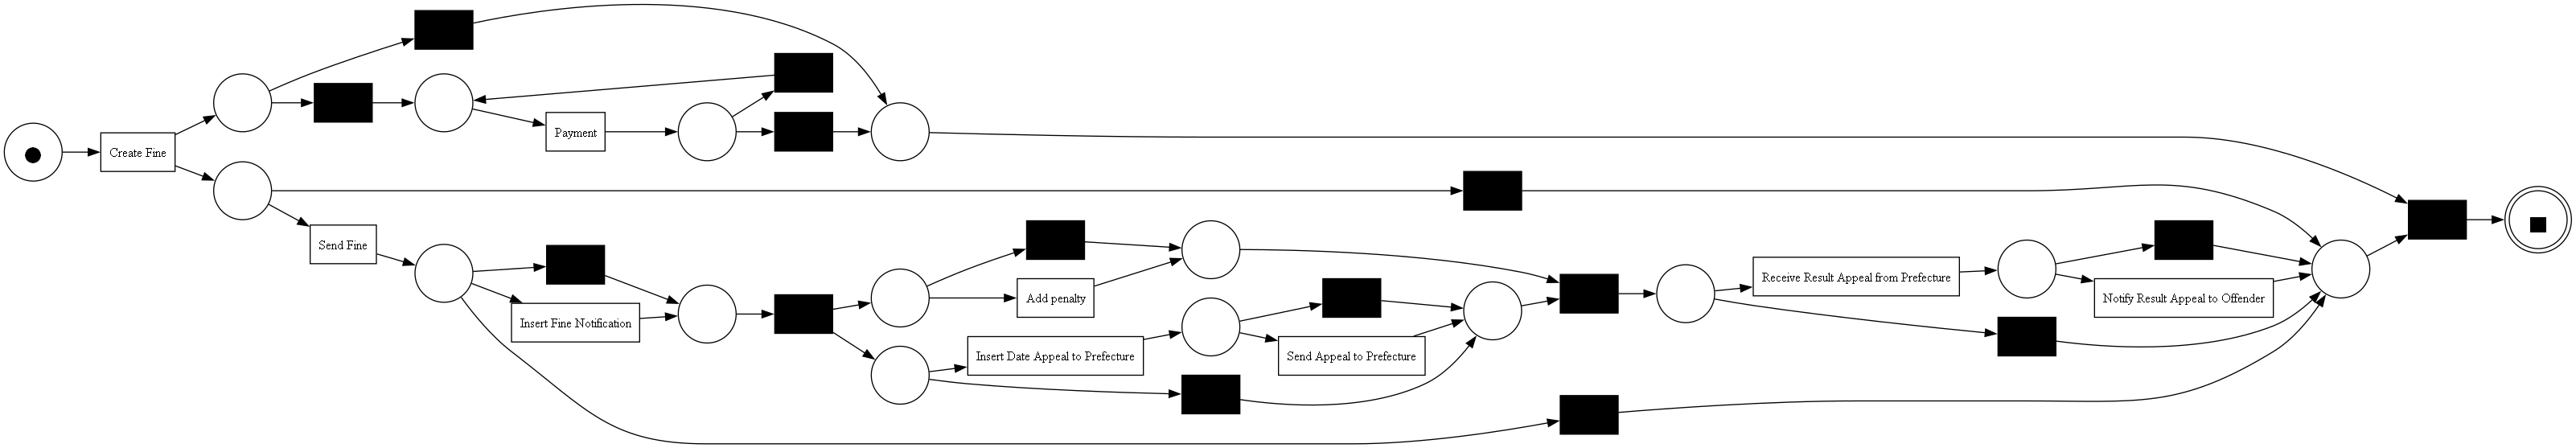

replaying log with TBR, completed traces ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/15 [00:00<?, ?it/s]

Item: C
Replay-based fitness: 1.0
Replay-based precision: 0.8441280241935484
Generalization: 0.7959259164023372
Simplicity: 0.6507936507936508



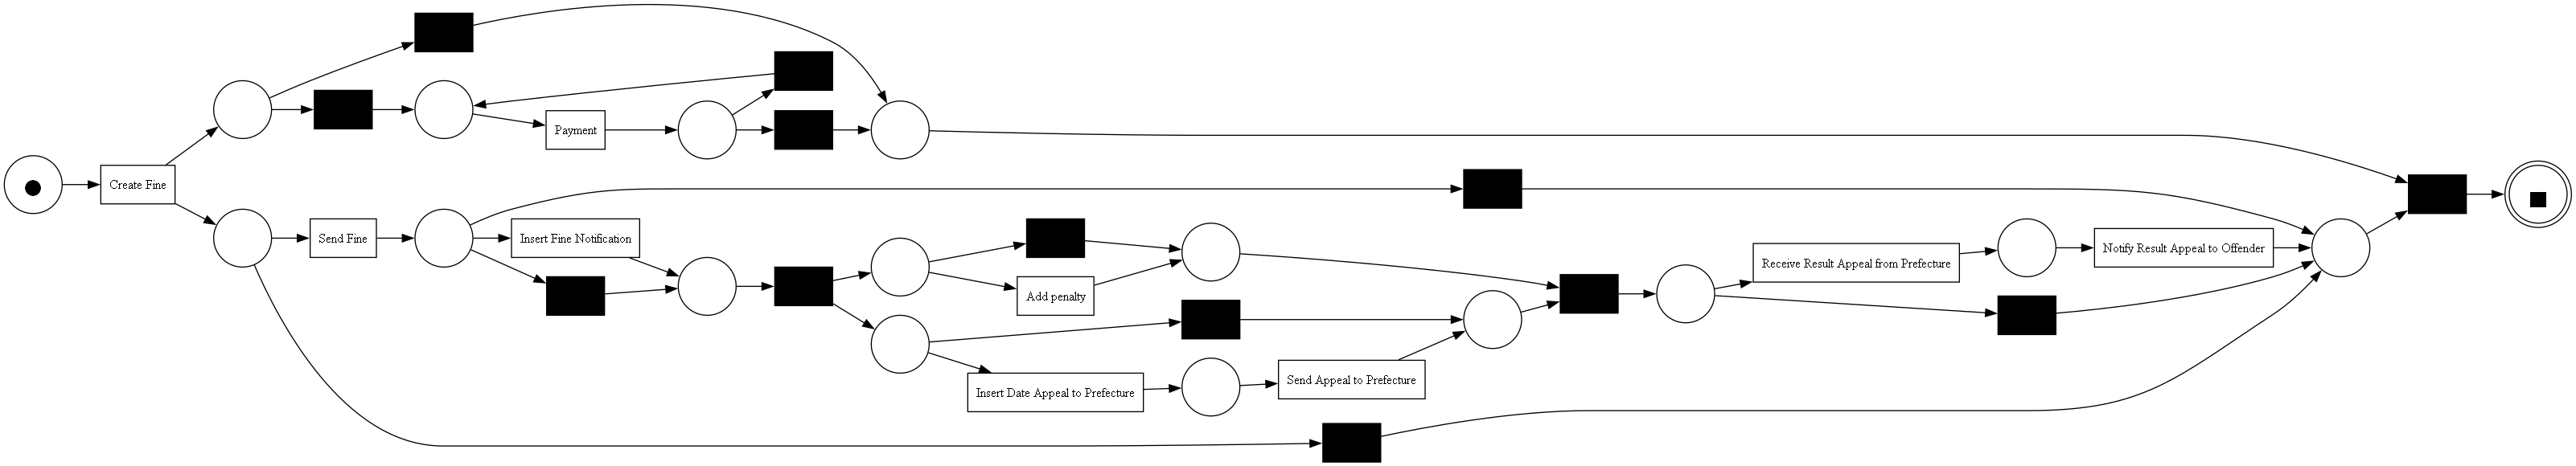

replaying log with TBR, completed traces ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/13 [00:00<?, ?it/s]

Item: M
Replay-based fitness: 1.0
Replay-based precision: 0.8442292171105731
Generalization: 0.7661197823578427
Simplicity: 0.6842105263157894



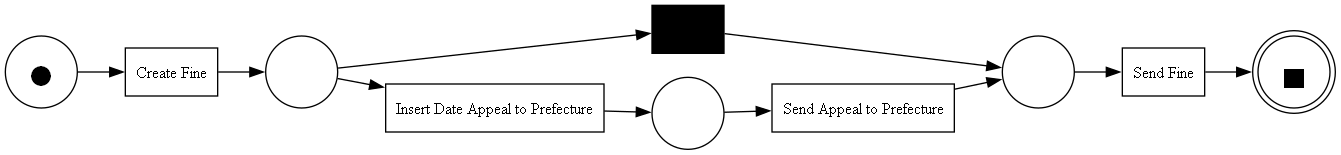

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

Item: R
Replay-based fitness: 1.0
Replay-based precision: 1.0
Generalization: 0.11715728752538102
Simplicity: 1.0



In [43]:
inductive_miner_heatmap = {}

for item in segmentedData:
    net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(segmentedData[item])
    pm4py.view_petri_net(net, initial_marking, final_marking)

    fitness = pm4py.fitness_token_based_replay(segmentedData[item], net, initial_marking, final_marking)
    precision = pm4py.precision_token_based_replay(segmentedData[item], net, initial_marking, final_marking)
    generalization = generalization_evaluator.apply(segmentedData[item], net, initial_marking, final_marking)
    simplicity = simplicity_evaluator.apply(net)

    inductive_miner_heatmap[item] = [fitness["log_fitness"], precision, generalization, simplicity]

    print("Item:", item)
    print("Replay-based fitness:", fitness["log_fitness"])
    print("Replay-based precision:", precision)
    print("Generalization:", generalization)
    print("Simplicity:", simplicity)
    print()


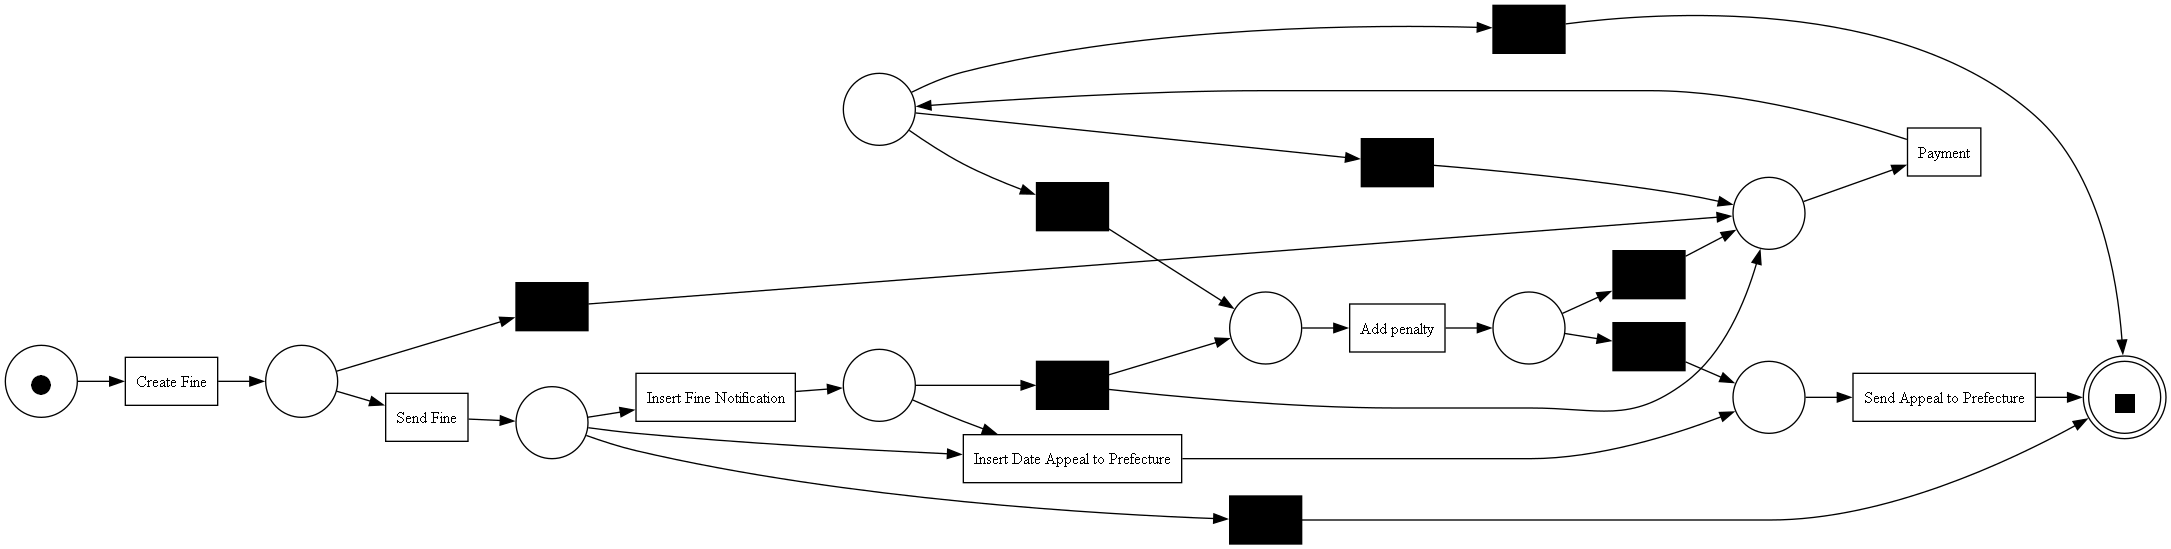

replaying log with TBR, completed traces ::   0%|          | 0/43 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/58 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/43 [00:00<?, ?it/s]

Item: A
Replay-based fitness: 0.9456263232203848
Replay-based precision: 0.9545715384058253
Generalization: 0.8882985580295102
Simplicity: 0.641025641025641



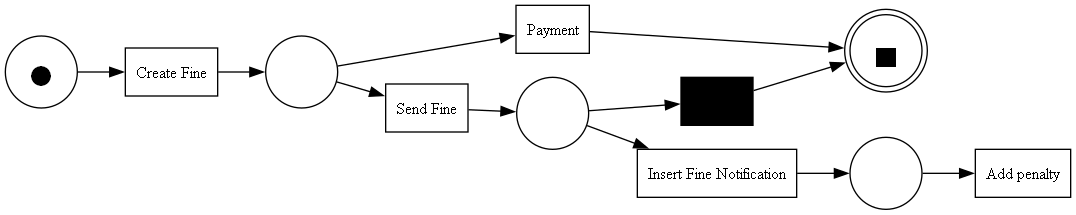

replaying log with TBR, completed traces ::   0%|          | 0/15 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/15 [00:00<?, ?it/s]

Item: C
Replay-based fitness: 0.9442181447847637
Replay-based precision: 0.998659260678031
Generalization: 0.948071355201257
Simplicity: 1.0



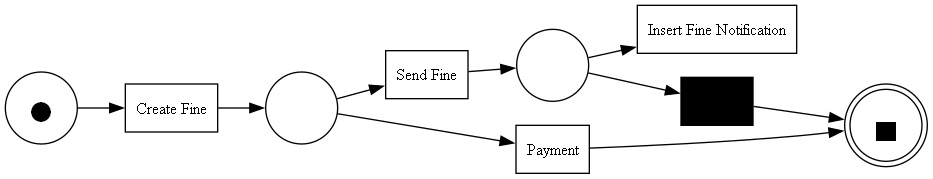

replaying log with TBR, completed traces ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/21 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/13 [00:00<?, ?it/s]

Item: M
Replay-based fitness: 0.9317044204482583
Replay-based precision: 0.9991216512955643
Generalization: 0.9297474656564998
Simplicity: 1.0



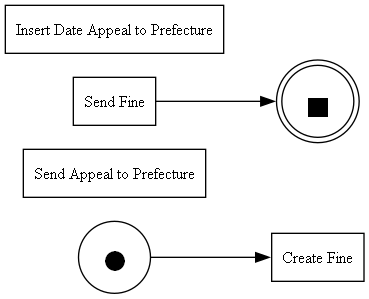

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

Item: R
Replay-based fitness: 1.0
Replay-based precision: 0.33333333333333337
Generalization: 0.14644660940672627
Simplicity: 1.0



In [44]:
heuristic_miner_heatmap = {}

for item in segmentedData:
    net, initial_marking, final_marking = pm4py.discover_petri_net_heuristics(
        segmentedData[item],
        dependency_threshold=0.99,
        and_threshold=0.99,
        loop_two_threshold=0.99
    )
    pm4py.view_petri_net(net, initial_marking, final_marking)

    fitness = pm4py.fitness_token_based_replay(segmentedData[item], net, initial_marking, final_marking)
    precision = pm4py.precision_token_based_replay(segmentedData[item], net, initial_marking, final_marking)
    generalization = generalization_evaluator.apply(segmentedData[item], net, initial_marking, final_marking)
    simplicity = simplicity_evaluator.apply(net)

    heuristic_miner_heatmap[item] = [fitness["log_fitness"], precision, generalization, simplicity]

    print("Item:", item)
    print("Replay-based fitness:", fitness["log_fitness"])
    print("Replay-based precision:", precision)
    print("Generalization:", generalization)
    print("Simplicity:", simplicity)
    print()


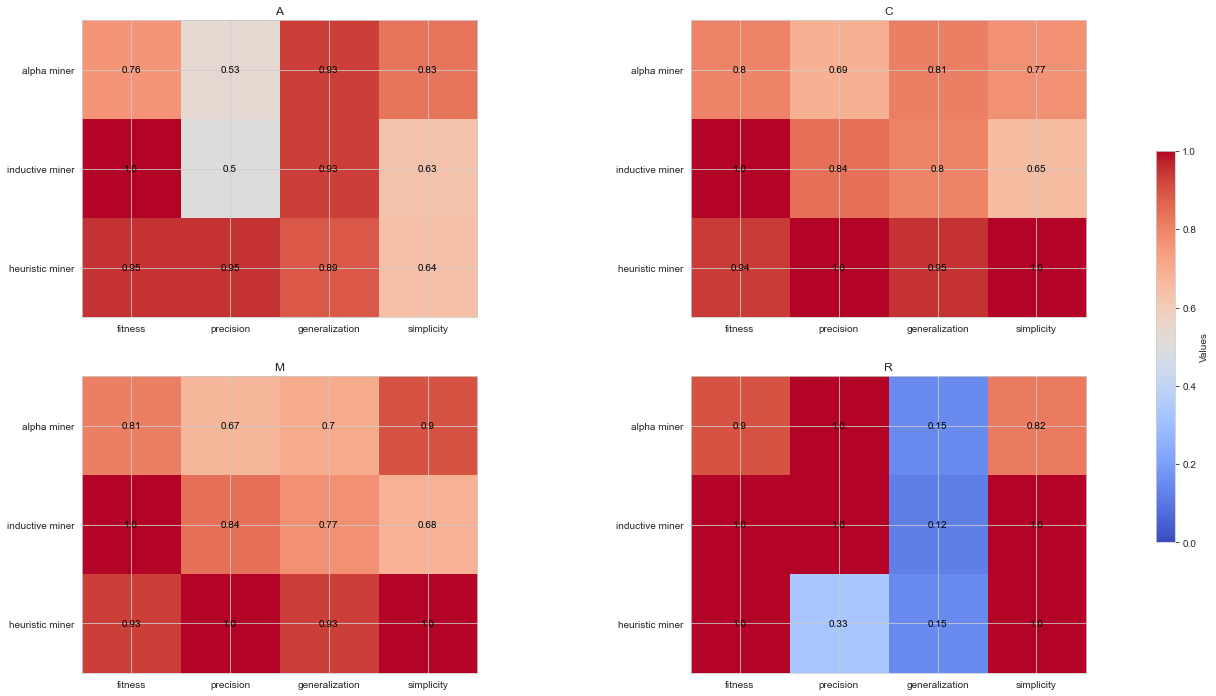

In [45]:
import numpy as np
import matplotlib.pyplot as plt

x_labels = ["fitness", "precision", "generalization", "simplicity"]
y_labels = ["alpha miner", "inductive miner", "heuristic miner"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25, 12))

for i, key in enumerate(alpha_miner_heatmap.keys()):
    row = i // 2
    col = i % 2
    values = np.array([
        alpha_miner_heatmap[key],
        inductive_miner_heatmap[key],
        heuristic_miner_heatmap[key]
    ])
    values = np.round(values, decimals=2)
    ax = axes[row, col]
    im = ax.imshow(values, cmap='coolwarm', vmin=0, vmax=1)  # Change the colormap to 'coolwarm'
    ax.set_title(key)
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_yticklabels(y_labels)
    for i in range(len(y_labels)):
        for j in range(len(x_labels)):
            text = ax.text(j, i, values[i, j], ha="center", va="center", color="black")

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
cbar.ax.set_ylabel('Values')

plt.show()


In [46]:
log_df

amount org:resource dismissal                concept:name  \
0         35.0          561       NIL                 Create Fine   
1          NaN          NaN       NaN                   Send Fine   
2         35.0          561       NIL                 Create Fine   
3          NaN          NaN       NaN                   Send Fine   
4          NaN          NaN       NaN    Insert Fine Notification   
...        ...          ...       ...                         ...   
561465   131.0           25       NIL                 Create Fine   
561466     NaN          NaN       NaN                   Send Fine   
561467     NaN          NaN       NaN    Insert Fine Notification   
561468   262.0          NaN       NaN                 Add penalty   
561469     NaN          NaN       NaN  Send for Credit Collection   

       vehicleClass  totalPaymentAmount lifecycle:transition  \
0                 A                 0.0             complete   
1               NaN                 NaN             complete   
2                 A                 0.0             complete   
3               NaN                 NaN             complete   
4               NaN                 NaN             complete   
...             ...                 ...                  ...   
561465            A                 0.0             complete   
561466          NaN                 NaN             complete   
561467          NaN                 NaN             complete   
561468          NaN                 NaN             complete   
561469          NaN                 NaN             complete   

                  time:timestamp  article  points case:concept:name  expense  \
0      2006-07-24 00:00:00+00:00    157.0     0.0                A1      NaN   
1      2006-12-05 00:00:00+00:00      NaN     NaN                A1    11.00   
2      2006-08-02 00:00:00+00:00    157.0     0.0              A100      NaN   
3      2006-12-12 00:00:00+00:00      NaN     NaN              A100    11.00   
4      2007-01-15 00:00:00+00:00      NaN     NaN              A100      NaN   
...                          ...      ...     ...               ...      ...   
561465 2002-09-07 00:00:00+00:00    142.0     0.0             V9999      NaN   
561466 2002-10-25 00:00:00+00:00      NaN     NaN             V9999    15.16   
561467 2002-11-04 00:00:00+00:00      NaN     NaN             V9999      NaN   
561468 2003-01-03 00:00:00+00:00      NaN     NaN             V9999      NaN   
561469 2004-01-10 00:00:00+00:00      NaN     NaN             V9999      NaN   

       notificationType lastSent  paymentAmount  matricola  
0                   NaN      NaN            NaN        NaN  
1                   NaN      NaN            NaN        NaN  
2                   NaN      NaN            NaN        NaN  
3                   NaN      NaN            NaN        NaN  
4                     P        P            NaN        NaN  
...                 ...      ...            ...        ...  
561465              NaN      NaN            NaN        NaN  
561466              NaN      NaN            NaN        NaN  
561467                P        N            NaN        NaN  
561468              NaN      NaN            NaN        NaN  
561469              NaN      NaN            NaN        NaN  

[561470 rows x 16 columns]

#**Clustering**


In [52]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [51]:
#Extract the features and encode them into onehot encoding vector
features_df = pm4py.extract_features_dataframe(log_df, str_ev_attr = ['concept:name', 'amount', 'paymentAmount'])
features_df = features_df .fillna(0)

In [55]:
log_df

amount org:resource dismissal                concept:name  \
0         35.0          561       NIL                 Create Fine   
1          NaN          NaN       NaN                   Send Fine   
2         35.0          561       NIL                 Create Fine   
3          NaN          NaN       NaN                   Send Fine   
4          NaN          NaN       NaN    Insert Fine Notification   
...        ...          ...       ...                         ...   
561465   131.0           25       NIL                 Create Fine   
561466     NaN          NaN       NaN                   Send Fine   
561467     NaN          NaN       NaN    Insert Fine Notification   
561468   262.0          NaN       NaN                 Add penalty   
561469     NaN          NaN       NaN  Send for Credit Collection   

       vehicleClass  totalPaymentAmount lifecycle:transition  \
0                 A                 0.0             complete   
1               NaN                 NaN             complete   
2                 A                 0.0             complete   
3               NaN                 NaN             complete   
4               NaN                 NaN             complete   
...             ...                 ...                  ...   
561465            A                 0.0             complete   
561466          NaN                 NaN             complete   
561467          NaN                 NaN             complete   
561468          NaN                 NaN             complete   
561469          NaN                 NaN             complete   

                  time:timestamp  article  points case:concept:name  expense  \
0      2006-07-24 00:00:00+00:00    157.0     0.0                A1      NaN   
1      2006-12-05 00:00:00+00:00      NaN     NaN                A1    11.00   
2      2006-08-02 00:00:00+00:00    157.0     0.0              A100      NaN   
3      2006-12-12 00:00:00+00:00      NaN     NaN              A100    11.00   
4      2007-01-15 00:00:00+00:00      NaN     NaN              A100      NaN   
...                          ...      ...     ...               ...      ...   
561465 2002-09-07 00:00:00+00:00    142.0     0.0             V9999      NaN   
561466 2002-10-25 00:00:00+00:00      NaN     NaN             V9999    15.16   
561467 2002-11-04 00:00:00+00:00      NaN     NaN             V9999      NaN   
561468 2003-01-03 00:00:00+00:00      NaN     NaN             V9999      NaN   
561469 2004-01-10 00:00:00+00:00      NaN     NaN             V9999      NaN   

       notificationType lastSent  paymentAmount  matricola  
0                   NaN      NaN            NaN        NaN  
1                   NaN      NaN            NaN        NaN  
2                   NaN      NaN            NaN        NaN  
3                   NaN      NaN            NaN        NaN  
4                     P        P            NaN        NaN  
...                 ...      ...            ...        ...  
561465              NaN      NaN            NaN        NaN  
561466              NaN      NaN            NaN        NaN  
561467                P        N            NaN        NaN  
561468              NaN      NaN            NaN        NaN  
561469              NaN      NaN            NaN        NaN  

[561470 rows x 16 columns]

In [56]:
column_names = features_df.columns.values.tolist() #get the list of all column names from headers
x = features_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler() #normilising with MinMaxScaler #be careful because when a value is always 1 the min max produce 0
x_scaled = min_max_scaler.fit_transform(x)
norm_df = pd.DataFrame(x_scaled)
norm_df.columns = column_names # adding column name to the respective columns


norm_df

amount  paymentAmount  concept:name_CreateFine  \
0       0.004375       0.000000                      0.0   
1       0.008938       0.000000                      0.0   
2       0.009250       0.021887                      0.0   
3       0.009250       0.000000                      0.0   
4       0.009250       0.000000                      0.0   
...          ...            ...                      ...   
150365  0.032750       0.000000                      0.0   
150366  0.016375       0.036770                      0.0   
150367  0.032750       0.000000                      0.0   
150368  0.032750       0.000000                      0.0   
150369  0.032750       0.000000                      0.0   

        concept:name_SendFine  concept:name_InsertFineNotification  \
0                         1.0                                  0.0   
1                         1.0                                  1.0   
2                         1.0                                  1.0   
3                         1.0                                  1.0   
4                         1.0                                  1.0   
...                       ...                                  ...   
150365                    1.0                                  1.0   
150366                    1.0                                  0.0   
150367                    1.0                                  1.0   
150368                    1.0                                  1.0   
150369                    1.0                                  1.0   

        concept:name_Addpenalty  concept:name_SendforCreditCollection  \
0                           0.0                                   0.0   
1                           1.0                                   1.0   
2                           1.0                                   0.0   
3                           1.0                                   0.0   
4                           1.0                                   1.0   
...                         ...                                   ...   
150365                      1.0                                   1.0   
150366                      0.0                                   0.0   
150367                      1.0                                   1.0   
150368                      1.0                                   1.0   
150369                      1.0                                   1.0   

        concept:name_Payment  concept:name_InsertDateAppealtoPrefecture  \
0                        0.0                                        0.0   
1                        0.0                                        0.0   
2                        1.0                                        0.0   
3                        0.0                                        1.0   
4                        0.0                                        0.0   
...                      ...                                        ...   
150365                   0.0                                        0.0   
150366                   1.0                                        0.0   
150367                   0.0                                        0.0   
150368                   0.0                                        0.0   
150369                   0.0                                        0.0   

        concept:name_SendAppealtoPrefecture  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       1.0   
4                                       0.0   
...                                     ...   
150365                                  0.0   
150366                                  0.0   
150367                                  0.0   
150368                                  0.0   
150369                                  0.0   

        concept:name_ReceiveResultAppealfromPrefecture  \
0                                              

#initialize kmeans parameters


In [57]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": None,
}

#create list to hold SSE (sum of squared errors) values for each k


In [58]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(norm_df)
    sse.append(kmeans.inertia_)


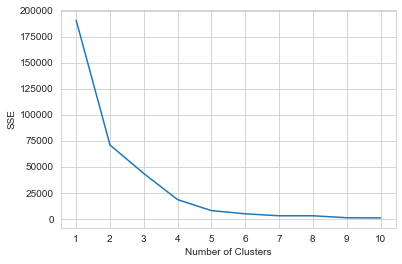

In [59]:
#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [60]:
#instantiate the k-means class, using optimal number of clusters
kmeans = KMeans(init="random", n_clusters=3, n_init=10, random_state=1)

#fit k-means algorithm to data
kmeans.fit(norm_df)

#view cluster assignments for each observation
kmeans.labels_

array([1, 0, 0, ..., 0, 0, 0])

In [61]:
#append cluster assingments to original DataFrame
features_df['cluster'] = kmeans.labels_

#view updated DataFrame
features_df

amount  paymentAmount  concept:name_CreateFine  concept:name_SendFine  \
0         35.0       0.000000                      1.0                    1.0   
1         71.5       0.000000                      1.0                    1.0   
2         74.0      87.000000                      1.0                    1.0   
3         74.0       0.000000                      1.0                    1.0   
4         74.0       0.000000                      1.0                    1.0   
...        ...            ...                      ...                    ...   
150365   262.0       0.000000                      1.0                    1.0   
150366   131.0     146.160004                      1.0                    1.0   
150367   262.0       0.000000                      1.0                    1.0   
150368   262.0       0.000000                      1.0                    1.0   
150369   262.0       0.000000                      1.0                    1.0   

        concept:name_InsertFineNotification  concept:name_Addpenalty  \
0                                       0.0                      0.0   
1                                       1.0                      1.0   
2                                       1.0                      1.0   
3                                       1.0                      1.0   
4                                       1.0                      1.0   
...                                     ...                      ...   
150365                                  1.0                      1.0   
150366                                  0.0                      0.0   
150367                                  1.0                      1.0   
150368                                  1.0                      1.0   
150369                                  1.0                      1.0   

        concept:name_SendforCreditCollection  concept:name_Payment  \
0                                        0.0                   0.0   
1                                        1.0                   0.0   
2                                        0.0                   1.0   
3                                        0.0                   0.0   
4                                        1.0                   0.0   
...                                      ...                   ...   
150365                                   1.0                   0.0   
150366                                   0.0                   1.0   
150367                                   1.0                   0.0   
150368                                   1.0                   0.0   
150369                                   1.0                   0.0   

        concept:name_InsertDateAppealtoPrefecture  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             1.0   
4                                             0.0   
...                                           ...   
150365                                        0.0   
150366                                        0.0   
150367                                        0.0   
150368                                        0.0   
150369                                        0.0   

        concept:name_SendAppealtoPrefecture  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       1.0   
4                                       0.0   
...                                     ...   
150365                                  0.0   
150366                                  0.0   
150367                                  0.0   
150368                                  0.0   
150369                                  0.0   

        concept:name_ReceiveResultAppealfromPrefecture  \
0                                                  0.0   
1          

In [64]:
features_df['case:concept:name']=log_df['case:concept:name']
# get the list of cases having 0 as a value of column cluster 
cluster1_cases = features_df[features_df['cluster'] == 0]['case:concept:name'].tolist()
cluster1_cases

['A1',
 'A100',
 'A100',
 'A100',
 'A10000',
 'A10000',
 'A10000',
 'A10000',
 'A10000',
 'A10001',
 'A10001',
 'A10001',
 'A10001',
 'A10001',
 'A10004',
 'A10004',
 'A10004',
 'A10007',
 'A10007',
 'A10008',
 'A10008',
 'A10008',
 'A10009',
 'A10009',
 'A1001',
 'A1001',
 'A10010',
 'A10010',
 'A10010',
 'A10010',
 'A10010',
 'A10011',
 'A10012',
 'A10015',
 'A10018',
 'A10018',
 'A10018',
 'A10019',
 'A10019',
 'A10019',
 'A1002',
 'A1002',
 'A10021',
 'A10022',
 'A10023',
 'A10023',
 'A10023',
 'A10023',
 'A10024',
 'A10024',
 'A10025',
 'A10025',
 'A10025',
 'A10025',
 'A10026',
 'A10026',
 'A10026',
 'A10029',
 'A10030',
 'A10030',
 'A10033',
 'A10033',
 'A10034',
 'A10041',
 'A10041',
 'A10042',
 'A10042',
 'A10042',
 'A10043',
 'A10044',
 'A10045',
 'A10046',
 'A10046',
 'A10046',
 'A10046',
 'A10047',
 'A10049',
 'A10049',
 'A10050',
 'A10050',
 'A10054',
 'A10054',
 'A10060',
 'A10061',
 'A10061',
 'A10063',
 'A10063',
 'A10063',
 'A10067',
 'A10067',
 'A10068',
 'A10068',
 '

In [65]:
cluster1_log = filtered_log[filtered_log['case:concept:name'].isin(cluster1_cases)]


In [66]:
num_events = len(cluster1_log)
num_cases = len(cluster1_log['case:concept:name'].unique())
print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))


Number of events: 33899
Number of cases: 13840


In [67]:
cluster2_cases = features_df[features_df['cluster'] == 1]['case:concept:name'].tolist()
# selecting rows based on condition 
cluster2_log = filtered_log[filtered_log['case:concept:name'].isin(cluster2_cases)]

num_events = len(cluster2_log)
num_cases = len(cluster2_log['case:concept:name'].unique())
print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))


Number of events: 14903
Number of cases: 5588


In [68]:
cluster3_cases = features_df[features_df['cluster'] == 2]['case:concept:name'].tolist()
# selecting rows based on condition 
cluster3_log = filtered_log[filtered_log['case:concept:name'].isin(cluster3_cases)]

num_events = len(cluster3_log)
num_cases = len(cluster3_log['case:concept:name'].unique())
print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))


Number of events: 23517
Number of cases: 9111


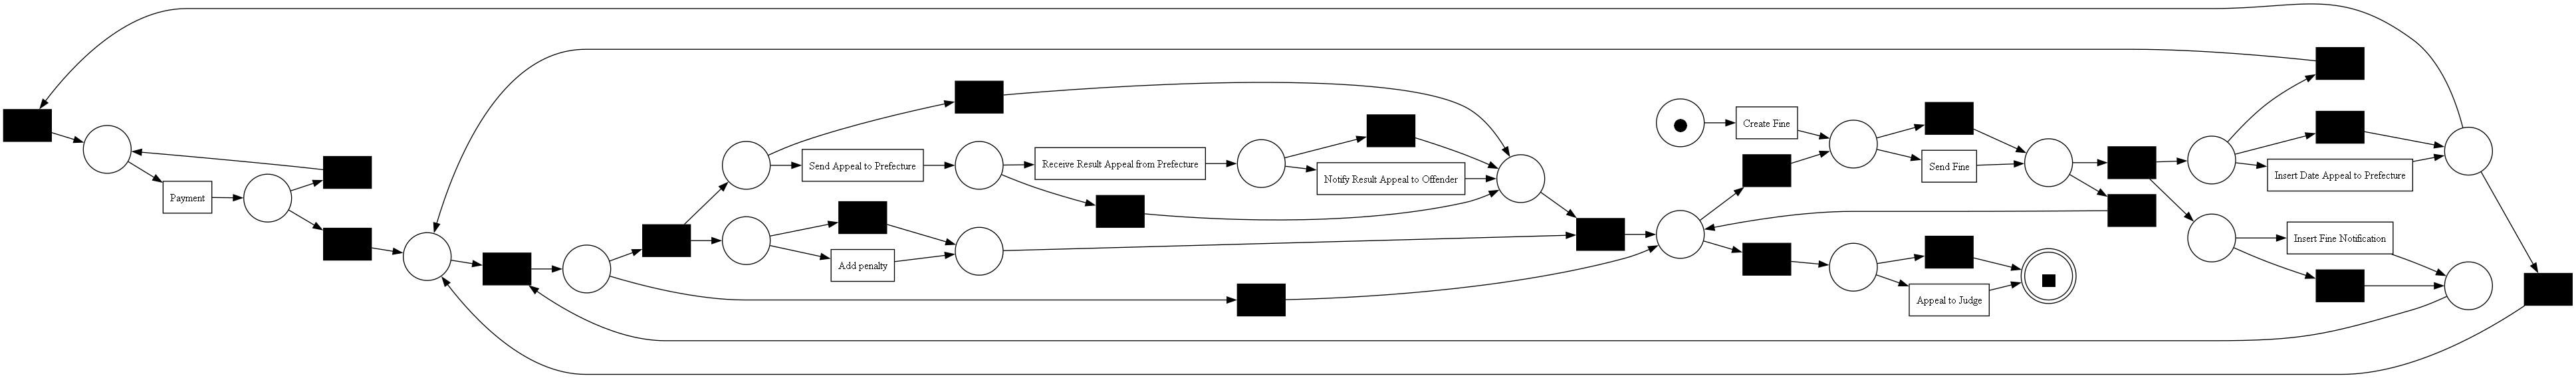

In [72]:
# create and visualize the petri net on clsuter1 using inductive miner
net, im, fm = pm4py.discover_petri_net_inductive(cluster1_log)
pm4py.view_petri_net(net, im, fm, format='png')


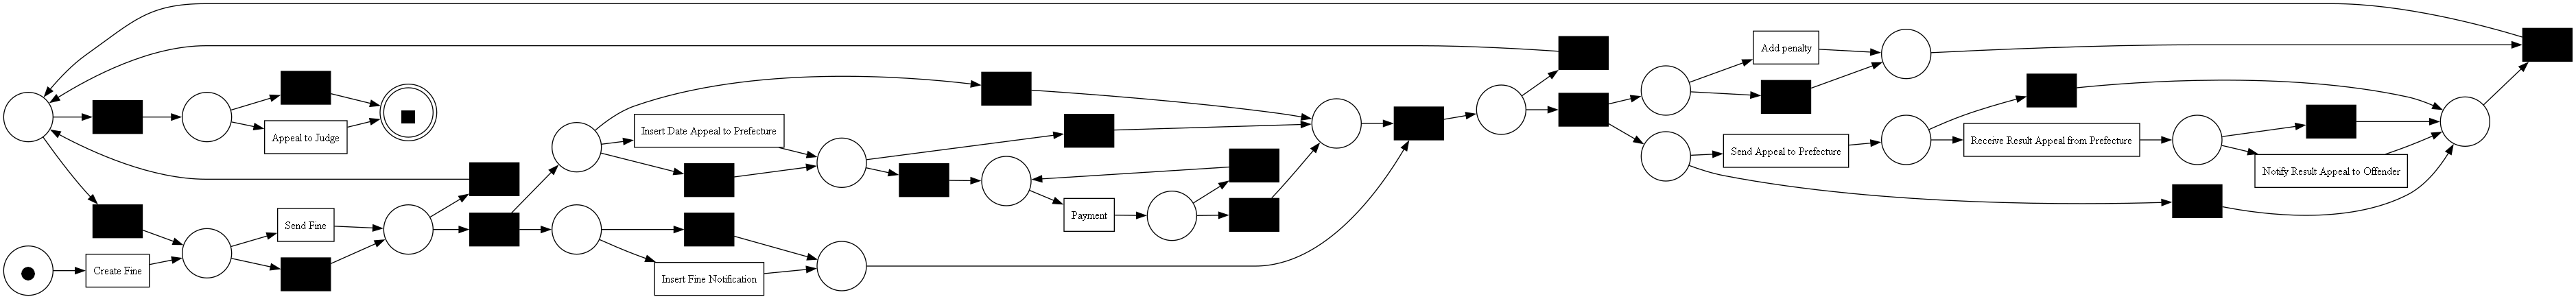

In [73]:
# create and visualize the petri net on clsuter2 using inductive miner
net, im, fm = pm4py.discover_petri_net_inductive(cluster2_log)
pm4py.view_petri_net(net, im, fm, format='png')


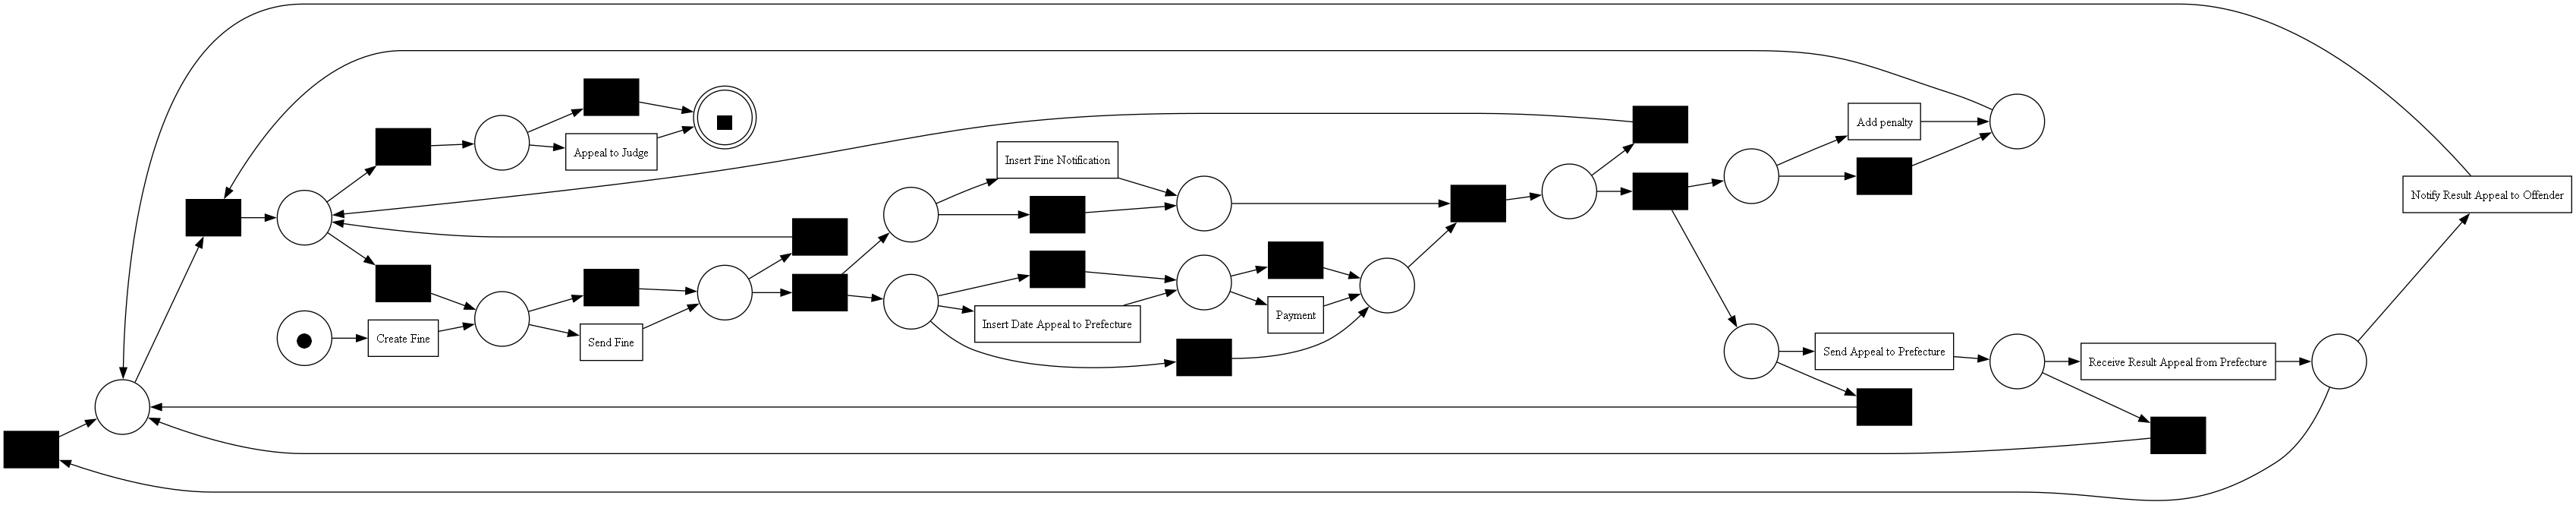

In [74]:
# create and visualize the petri net on clsuter3 using inductive miner
net, im, fm = pm4py.discover_petri_net_inductive(cluster3_log)
pm4py.view_petri_net(net, im, fm, format='png')


#**DecisionTree**

In [76]:
#split dataset in features and target variable
feature_cols =  [x for x in column_names if x != "concept:name_Payment"]
feature_cols =  [x for x in feature_cols if x != "paymentAmount"]
print(feature_cols)

['amount', 'concept:name_CreateFine', 'concept:name_SendFine', 'concept:name_InsertFineNotification', 'concept:name_Addpenalty', 'concept:name_SendforCreditCollection', 'concept:name_InsertDateAppealtoPrefecture', 'concept:name_SendAppealtoPrefecture', 'concept:name_ReceiveResultAppealfromPrefecture', 'concept:name_NotifyResultAppealtoOffender', 'concept:name_AppealtoJudge']


In [77]:
X = norm_df[feature_cols] # Features, can be numerical or categorical
y = norm_df['concept:name_Payment'] # Target variable, must be categorical

In [78]:
from sklearn.model_selection import train_test_split
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test#


In [80]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)


In [81]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.9598989160071822


In [86]:
from six import StringIO 
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('BisRoad.png')
Image(graph.create_png())


In [83]:
#Extracts a dataframe containing the temporal features of the provided log object
temporal_features_df = pm4py.extract_temporal_features_dataframe(filtered_log, grouper_freq = 'M')

temporal_features_df


timestamp  unique_resources  unique_cases  \
0   2000-01-31 00:00:00+00:00                23           270   
1   2000-02-29 00:00:00+00:00                22           315   
2   2000-03-31 00:00:00+00:00                24           524   
3   2000-04-30 00:00:00+00:00                25           471   
4   2000-05-31 00:00:00+00:00                42           607   
..                        ...               ...           ...   
157 2013-02-28 00:00:00+00:00                21           365   
158 2013-03-31 00:00:00+00:00                35           397   
159 2013-04-30 00:00:00+00:00                46           486   
160 2013-05-31 00:00:00+00:00                45           801   
161 2013-06-30 00:00:00+00:00                26           805   

     unique_activities  num_events  average_arrival_rate  average_finish_rate  \
0                    3         396           8960.000000         19520.000000   
1                    4         421          10971.428571         17828.571429   
2                    6         723           7254.961832         15993.893130   
3                    7         617           9171.974522         14308.280255   
4                    7         800           9252.059308         14376.276771   
..                 ...         ...                   ...                  ...   
157                  8         501          16096.438356         14676.164384   
158                  9         493          12405.037783          9575.818640   
159                  8         556          10844.444444          7822.222222   
160                  8         975           8413.483146          4206.741573   
161                  4         901           7835.031056          1931.925466   

     average_waiting_time  average_sojourn_time  average_service_time  
0            3.970240e+06          3.970240e+06                   0.0  
1            4.643383e+06          4.643383e+06                   0.0  
2            5.517893e+06          5.517893e+06                   0.0  
3            7.351704e+06          7.351704e+06                   0.0  
4            8.044737e+06          8.044737e+06                   0.0  
..                    ...                   ...                   ...  
157          9.593477e+06          9.593477e+06                   0.0  
158          6.913523e+06          6.913523e+06                   0.0  
159          5.009600e+06          5.009600e+06                   0.0  
160          3.282445e+06          3.282445e+06                   0.0  
161          3.325058e+06          3.325058e+06                   0.0  

[162 rows x 10 columns]